Research Question:
What set of factors is most important in determining adult violent crime rates across U.S. states from 2013-2018? How could we use these factors to accurately predict future violent crime rates?

sources:
using inplace for the rename function: https://www.geeksforgeeks.org/what-does-inplace-mean-in-pandas/

In [215]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

Data Overview: 
Jasmine

Data Cleaning

In [216]:
East = ["Maine", "New Hampshire", "Rhode Island", 'Connecticut',
        'New York', 'Massachusetts', 'New jersey', 'Florida', 'Georgia',
        'Maryland', 'North Carolina', 'South Carolina', 'Virginia'
        ]
West = ['Alaska', 'Washington', 'Oregon', 'California', 'Hawaii',
        'Utah', 'Idaho', 'Monatana', 'Nevada']

In [217]:
#loading crime data
crime_df = pd.read_csv('data/crime.csv')
print(crime_df.iloc[:, 2:])

      Unnamed: 2  Unnamed: 3     Unnamed: 4 Unnamed: 5   Unnamed: 6  \
0     state_name  population  violent_crime   homicide  rape_legacy   
1            NaN   220099000        1208030      21460        76390   
2         Alaska      406000           1994         54          292   
3        Alabama     3769000          15578        496         1037   
4       Arkansas     2180000           7984        198          595   
...          ...         ...            ...        ...          ...   
2332         NaN   8,715,698         20,589        520          NaN   
2333         NaN   7,812,880         27,909        373          NaN   
2334         NaN   1,770,071          4,699         87          NaN   
2335         NaN   5,910,955         17,057        283          NaN   
2336         NaN     584,057          1,116         18          NaN   

        Unnamed: 7 Unnamed: 8          Unnamed: 9     Unnamed: 10 Unnamed: 11  \
0     rape_revised    robbery  aggravated_assault  property_crime 

In [218]:
#see what the names of each column are without any edits to the csv
print(crime_df.columns)

#rename the columns we want with proper names
crime_df.rename(columns={
    'estimated_crimes_1979_2023': 'Year',
    'Unnamed: 1': 'State_Abbreviation',
    'Unnamed: 2': 'State_Name',
    'Unnamed: 3': 'Population',
    'Unnamed: 4': 'Violent_Crime',
    'Unnamed: 5': 'Homicide',
    'Unnamed: 6': 'Rape',
    'Unnamed: 7': 'Rape_Revised',
    'Unnamed: 8': 'Robbery',
    'Unnamed: 9': 'Aggravated_Assault'
},inplace=True)

#drop columns that will not be used during the analysis
crime_df = crime_df.drop(columns=['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'])
print(crime_df)


Index(['estimated_crimes_1979_2023', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')
      Year State_Abbreviation  State_Name  Population  Violent_Crime  \
0     year         state_abbr  state_name  population  violent_crime   
1     1979                NaN         NaN   220099000        1208030   
2     1979                 AK      Alaska      406000           1994   
3     1979                 AL     Alabama     3769000          15578   
4     1979                 AR    Arkansas     2180000           7984   
...    ...                ...         ...         ...            ...   
2332  2023                 VA         NaN   8,715,698         20,589   
2333  2023                 WA         NaN   7,812,880         27,909   
2334  2023                 WV         NaN   1,770,071          4,699  

In [219]:
#dropping the first row (index 0) and reset the indexes. This way, I can turn the year from object to integer.
crime_df = crime_df.drop(index=0)


In [220]:
#if rape_Revised is na, take rape
na_rape_values = crime_df['Rape'].loc[crime_df['Rape_Revised'].isna()] #put this into rape_revised

crime_df['Rape_Revised'] = crime_df['Rape_Revised'].fillna(na_rape_values)

crime_df = crime_df.drop(columns = ['Rape'])

crime_df.rename(columns= {'Rape_Revised':'Rape'}, inplace=True)
crime_df.head()

,Year,State_Abbreviation,State_Name,Population,Violent_Crime,Homicide,Rape,Robbery,Aggravated_Assault
1,1979,NaN,NaN,220099000,1208030,21460,76390,480700,629480
2,1979,AK,Alaska,406000,1994,54,292,445,1203
3,1979,AL,Alabama,3769000,15578,496,1037,4127,9918
4,1979,AR,Arkansas,2180000,7984,198,595,1626,5565
5,1979,AZ,Arizona,2450000,14528,219,1120,4305,8884


In [221]:
# Reset the index
crime_df.reset_index(drop=True, inplace=True)

#making the year into an interger from an object
crime_df['Year']=crime_df['Year'].astype(int)

#shaping the data set so that we are only looking at years 2013 to 2018
crime_filtered_years = crime_df[(crime_df['Year'] >= 2013) & (crime_df['Year'] <= 2018)]

# Drop rows where 'State_Abbreviation' or 'State_Name' is NaN
crime_filtered_years = crime_filtered_years.dropna(subset=['State_Abbreviation', 'State_Name'])
crime_filtered_years.reset_index(inplace=True, drop = True)
print(crime_filtered_years)

     Year State_Abbreviation     State_Name Population Violent_Crime Homicide  \
0    2013                 AK         Alaska     737259          4709       34   
1    2013                 AL        Alabama    4833996         20834      346   
2    2013                 AR       Arkansas    2958765         13705      158   
3    2013                 AZ        Arizona    6634997         27576      355   
4    2013                 CA     California   38431393        154739     1746   
..    ...                ...            ...        ...           ...      ...   
301  2018                 VT        Vermont     624358          1155       11   
302  2018                 WA     Washington    7523869         23719      236   
303  2018                 WI      Wisconsin    5807406         17365      175   
304  2018                 WV  West Virginia    1804291          5411       76   
305  2018                 WY        Wyoming     577601          1235       14   

      Rape Robbery Aggravat

In [222]:
crime_filtered_years['Population'] = crime_filtered_years['Population'].astype(int)
crime_filtered_years['Rape'] = crime_filtered_years['Rape'].astype(int)
crime_filtered_years['Robbery'] = crime_filtered_years['Robbery'].astype(int)
crime_filtered_years['Aggravated_Assault'] = crime_filtered_years['Aggravated_Assault'].astype(int)
crime_filtered_years['Violent_Crime'] = crime_filtered_years['Violent_Crime'].astype(int)
crime_filtered_years['Homicide'] = crime_filtered_years['Homicide'].astype(int)
crime_filtered_years.dtypes

Year                   int64
State_Abbreviation    object
State_Name            object
Population             int64
Violent_Crime          int64
Homicide               int64
Rape                   int64
Robbery                int64
Aggravated_Assault     int64
dtype: object

In [223]:
crime_filtered_years['Sum'] = crime_filtered_years['Rape'] + crime_filtered_years['Robbery'] + \
  crime_filtered_years['Aggravated_Assault']+crime_filtered_years['Homicide']
crime_filtered_years.rename(columns={'State_Name': 'State'}, inplace=True)
crime_df = crime_filtered_years

print(crime_filtered_years.loc[:,['Violent_Crime','Sum']])

     Violent_Crime     Sum
0             4709    4709
1            20834   20834
2            13705   13705
3            27576   27576
4           154739  154739
..             ...     ...
301           1155    1155
302          23719   23719
303          17365   17365
304           5411    5411
305           1235    1235

[306 rows x 2 columns]


In [224]:
#loading poverty data
poverty_df = pd.read_csv('data/poverty.csv')
print(poverty_df)

                                             Unnamed: 0        Unnamed: 1  \
0     Table 19. Number of Poor and Poverty Rate by S...               NaN   
1     (Population in thousands. Population as of Mar...               NaN   
2                                                  2023               NaN   
3                                                 State  Total population   
4                                               Alabama             4,995   
...                                                 ...               ...   
2437                                      West Virginia             1,952   
2438                                          Wisconsin             4,724   
2439                                            Wyoming               468   
2440  Source: U.S. Census Bureau, Current Population...               NaN   
2441  Footnotes are available at <www.census.gov/top...               NaN   

             Unnamed: 2                Unnamed: 3          Unnamed: 4  \
0 

In [225]:
#cleaning the first few rows that are just words
poverty_df = poverty_df.drop([0, 1])

poverty_df.rename(columns={'Unnamed: 0':'State',
                           'Unnamed: 1': 'TotalPop',
                           'Unnamed: 2':'PovertyTotal',
                           'Unnamed: 3': 'Margin_1',
                           'Unnamed: 4': 'PovertyPercent',
                           'Unnamed: 5': "Margin_2"}, inplace=True)
#print(poverty_df.columns)
#cutting off any row that is not between 2013 and 2018
index_2018 = poverty_df[poverty_df['State'] == '2018'].index[0]
index_2017 = poverty_df[poverty_df['State'] == '2017 (3)'].index[0]
print(index_2018)
print(index_2017)


267
320


In [226]:
poverty_2018 = poverty_df[index_2018:index_2017-2]
print(poverty_2018.head())
print(poverty_2018.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
269     Alabama    4,877          779      107           16.0      2.1
270      Alaska      720           94       15           13.1      2.0
271     Arizona    7,241          929      132           12.8      1.8
272    Arkansas    2,912          462       63           15.9      2.1
273  California   39,150        4,664      303           11.9      0.8
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
315       Virginia    8,393          821      141            9.8      1.6
316     Washington    7,555          647      166            8.6      2.1
317  West Virginia    1,762          279       35           15.9      2.0
318      Wisconsin    5,795          499       89            8.6      1.5
319        Wyoming      565           53       10            9.5      1.8


In [227]:
index_2017 = poverty_df[poverty_df['State'] == '2017'].index[0]
index_2016 = poverty_df[poverty_df['State'] == '2016'].index[0]
print(index_2017)
print(index_2016)
poverty_2017 = poverty_df[index_2017:index_2016-2]
print(poverty_2017.tail())
#print(poverty_2017.tail(53))

373
426
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
421       Virginia    8,249          847      127           10.3      1.5
422     Washington    7,431          736      104            9.9      1.5
423  West Virginia    1,794          311       46           17.3      2.5
424      Wisconsin    5,808          551       71            9.5      1.2
425        Wyoming      560           70       13           12.4      2.3


In [228]:
index_2015 = poverty_df[poverty_df['State'] == '2015'].index[0]

poverty_2016 = poverty_df[index_2016:index_2015-2]
print(poverty_2016.head())
print(poverty_2016.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
428     Alabama    4,821          782      104           16.2      2.1
429      Alaska      708           89       20           12.6      2.8
430     Arizona    6,878        1,108      130           16.1      1.8
431    Arkansas    2,941          471       46           16.0      1.5
432  California   39,140        5,435      288           13.9      0.7
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
474       Virginia    8,163          929      137           11.4      1.6
475     Washington    7,289          800       99           11.0      1.3
476  West Virginia    1,808          326       51           18.0      2.8
477      Wisconsin    5,764          620       84           10.7      1.5
478        Wyoming      571           62       12           10.9      2.0


In [229]:
index_2014 = poverty_df[poverty_df['State'] == '2014'].index[0]

poverty_2015 = poverty_df[index_2015:index_2014-2]
print(poverty_2015.head())
print(poverty_2015.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
481     Alabama    4,820          784       99           16.3      2.0
482      Alaska      703           65       10            9.2      1.5
483     Arizona    6,728        1,156      138           17.2      2.1
484    Arkansas    2,951          475       44           16.1      1.5
485  California   39,080        5,441      347           13.9      0.8
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
527       Virginia    8,216          894      133           10.9      1.6
528     Washington    7,193          819       89           11.4      1.3
529  West Virginia    1,795          261       76           14.5      4.3
530      Wisconsin    5,736          654      112           11.4      2.0
531        Wyoming      574           56       13            9.8      2.3


In [230]:
index_2013 = poverty_df[poverty_df['State'] == '2013 (4)'].index[0]
poverty_2014 = poverty_df[index_2014:index_2013-2]
print(poverty_2014.head())
print(poverty_2014.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
534     Alabama    4,765          848       87           17.8      1.8
535      Alaska      694           82       13           11.9      2.0
536     Arizona    6,657        1,409      125           21.2      1.8
537    Arkansas    2,891          532       72           18.4      2.5
538  California   38,670        6,112      359           15.8      1.0
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
580       Virginia    8,257          842      120           10.2      1.5
581     Washington    7,079          852      135           12.0      2.0
582  West Virginia    1,822          376       49           20.6      2.8
583      Wisconsin    5,742          628       90           10.9      1.6
584        Wyoming      572           55       10            9.7      1.8


In [231]:
index_2013 = poverty_df[poverty_df['State'] == '2013 (5)'].index[0]
index_2012 = poverty_df[poverty_df['State'] == '2012'].index[0]
poverty_2013 = poverty_df[index_2013:index_2012-2]
print(poverty_2013.head())
print(poverty_2013.tail())


          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
640     Alabama    4,751          796      110           16.7      2.3
641      Alaska      696           76       20           10.9      2.8
642     Arizona    6,645        1,345      153           20.2      2.3
643    Arkansas    2,940          504      114           17.1      3.9
644  California   38,050        5,675      352           14.9      1.0
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
686       Virginia    8,174          854      165           10.4      2.0
687     Washington    6,854          819      133           12.0      2.0
688  West Virginia    1,823          315       58           17.3      3.1
689      Wisconsin    5,625          618      115           11.0      2.0
690        Wyoming      578           68       10           11.8      1.8


In [232]:
poverty_2018 = poverty_2018.copy()
poverty_2018['Year'] = 2018
poverty_2017 = poverty_2017.copy()
poverty_2017['Year'] = 2017
poverty_2016= poverty_2016.copy()
poverty_2016['Year'] = 2016
poverty_2015 = poverty_2015.copy()
poverty_2015['Year'] = 2015
poverty_2014 = poverty_2014.copy()
poverty_2014['Year'] = 2014
poverty_2013 = poverty_2013.copy()
poverty_2013['Year'] = 2013

poverty_concat = pd.concat([poverty_2013, poverty_2014, poverty_2015, poverty_2016, poverty_2017, poverty_2018], axis=0)
poverty_concat.reset_index(inplace=True, drop=True)
print(poverty_concat)


             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2  \
0          Alabama    4,751          796      110           16.7      2.3   
1           Alaska      696           76       20           10.9      2.8   
2          Arizona    6,645        1,345      153           20.2      2.3   
3         Arkansas    2,940          504      114           17.1      3.9   
4       California   38,050        5,675      352           14.9      1.0   
..             ...      ...          ...      ...            ...      ...   
301       Virginia    8,393          821      141            9.8      1.6   
302     Washington    7,555          647      166            8.6      2.1   
303  West Virginia    1,762          279       35           15.9      2.0   
304      Wisconsin    5,795          499       89            8.6      1.5   
305        Wyoming      565           53       10            9.5      1.8   

     Year  
0    2013  
1    2013  
2    2013  
3    2013  
4    2013  
.. 

In [233]:
poverty_concat['PovertyTotal'] = poverty_concat.PovertyTotal.str.replace(",", '').astype(int)
poverty_concat['Margin_1'] = poverty_concat['Margin_1'].astype(float)
poverty_concat['Margin_2'] = poverty_concat['Margin_2'].astype(float)
poverty_concat['PovertyPercent'] = poverty_concat['PovertyPercent'].astype(float)
poverty_concat['TotalPop'] = poverty_concat.TotalPop.str.replace(",", '').astype(int)
poverty_concat.dtypes


State              object
TotalPop            int64
PovertyTotal        int64
Margin_1          float64
PovertyPercent    float64
Margin_2          float64
Year                int64
dtype: object

In [234]:
pop_df = pd.read_csv('data/population.csv', thousands = ',')
pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Table 1. Annual Estimates of the Resident Popu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,"April 1, 2010",NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,"308,745,538","308,758,105","309,321,666",311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,Northeast,"55,317,240","55,318,443","55,380,134",55604223.0,55775216.0,55901806.0,56006011.0,56034684.0,56042330.0,56059240.0,56046620.0,55982803.0


In [235]:
# remove unncessary rows; we only want the states

pop_df = pop_df.loc[8:, :].reset_index(drop = True)
pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,.Alabama,"4,779,736","4,780,125","4,785,437",4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
1,.Alaska,"710,231","710,249","713,910",722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
2,.Arizona,"6,392,017","6,392,288","6,407,172",6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0
3,.Arkansas,"2,915,918","2,916,031","2,921,964",2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0
4,.California,"37,253,956","37,254,519","37,319,502",37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0


In [236]:
#only want the columns that have the states' names and population data from 2013 to 2018
#knew to take columns unnamed 6 to 11 because of the year information (row index 2) from the entire dataset from the first head()

pop_df = pop_df.loc[:, ["table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)",
                        "Unnamed: 6", "Unnamed: 7","Unnamed: 8",
                        "Unnamed: 9", "Unnamed: 10", "Unnamed: 11"]]

pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,.Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,.Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,.Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,.Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,.California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [237]:
#rename the columns properly and accordingly

pop_df.rename(columns= {"table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)": "State",
                        "Unnamed: 6": "2013", "Unnamed: 7": '2014',
                        "Unnamed: 8": '2015', "Unnamed: 9":'2016',
                        "Unnamed: 10":'2017', "Unnamed: 11":'2018'}, inplace=True)
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,.Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,.Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,.Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,.Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,.California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [238]:
#remove the period in front of the states' names to clean it up
pop_df['State'] = pop_df['State'].str.replace('.', '')
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [239]:
# remove excess rows that are not states
pop_df = pop_df.loc[:50, :].reset_index(drop = True)
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [240]:
job_df = pd.read_csv('emp_table.csv')
job_df.head()

,Average Annual Unemployment Rates by State (see previous tab for Iowa's counties),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,U.S. Bureau of Labor Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Local Area Unemployment Statistics and Current...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,April 2019 release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fips,Area,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0


In [241]:
job_df = job_df.loc[4:, :].reset_index(drop=True)
job_df.head()

,Average Annual Unemployment Rates by State (see previous tab for Iowa's counties),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,Fips,Area,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,00000,United States,7.1,7.6,9.7,9.6,7.5,7.2,7.0,6.2,...,9.3,9.6,8.9,8.1,7.4,6.2,5.3,4.9,4.4,3.9
2,01000,Alabama,8.9,10.6,14.1,13.8,11.0,9.2,9.7,8.1,...,11.0,10.5,9.6,8.0,7.2,6.8,6.1,5.8,4.4,3.9
3,02000,Alaska,9.6,9.4,9.9,9.9,9.8,9.7,10.9,10.3,...,7.7,7.9,7.6,7.1,7.0,6.9,6.5,6.9,7.0,6.6
4,04000,Arizona,6.6,6.2,10.1,8.8,5.2,6.3,6.9,6.5,...,9.9,10.4,9.5,8.3,7.7,6.8,6.1,5.4,4.9,4.8


In [242]:
job_df = job_df.loc[:, ["Unnamed: 1", "Unnamed: 35","Unnamed: 36",
                        "Unnamed: 37", "Unnamed: 38", "Unnamed: 39", "Unnamed: 40"]]
job_df.head()

,Unnamed: 1,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,Area,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,United States,7.4,6.2,5.3,4.9,4.4,3.9
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8


In [243]:
job_df.rename(columns= {"Unnamed: 1": "Area", "Unnamed: 35": "2013", "Unnamed: 36": '2014',
                        "Unnamed: 37": '2015', "Unnamed: 38":'2016',
                        "Unnamed: 39":'2017', "Unnamed: 40":'2018'}, inplace=True)
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
0,Area,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,United States,7.4,6.2,5.3,4.9,4.4,3.9
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8


In [244]:
job_df = job_df.loc[2:52, :]
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8
5,Arkansas,7.2,6.0,5.0,4.0,3.7,3.7
6,California,8.9,7.5,6.2,5.5,4.8,4.2


In [245]:
job_df.reset_index(inplace=True, drop=True)
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
0,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
1,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
2,Arizona,7.7,6.8,6.1,5.4,4.9,4.8
3,Arkansas,7.2,6.0,5.0,4.0,3.7,3.7
4,California,8.9,7.5,6.2,5.5,4.8,4.2


In [246]:
income_df = pd.read_csv("data/income.csv")
income_df.head(5)

,"Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74
0,Table H-8. Median Household Income by State: ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(Households as of March of the following year....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CURRENT DOLLARS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,State,2018,NaN,2017 (40),NaN,2017,NaN,2016,NaN,2015,...,1988,NaN,1987 (21),NaN,1986,NaN,1985 (20),NaN,1984 (19),NaN
4,NaN,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,...,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror


In [247]:
income_df.drop(columns={'Unnamed: 12','Unnamed: 10','Unnamed: 8', 'Unnamed: 6', 'Unnamed: 4', 'Unnamed: 2' , 'Unnamed: 3'}, inplace=True)
print(income_df.columns)
(income_df.iloc[3:, :15]).head()

Index(['Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61',
       'Unnamed: 1', 'Unnamed: 5', 'Unnamed: 7', 'Unnamed: 9', 'Unnamed: 11',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44',
       'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48',
       'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'Unnamed: 61', '

,"Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61",Unnamed: 1,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
3,State,2018,2017,2016,2015,2014,2013 (39),NaN,2013 (38),NaN,2012,NaN,2011,NaN,2010 (37)
4,NaN,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome
5,United States,"63,179","61,372","59,039","56,516","53,657","53,585",654,"51,939",276,"51,017",209,"50,054",251,"49,276"
6,Alabama,"49,936","51,113","47,221","44,509","42,278","47,320","5,511","41,381","2,315","43,464","2,529","42,590","2,021","40,933"
7,Alaska,"68,734","72,231","75,723","75,112","67,629","72,472","5,446","61,137","3,301","63,648","2,839","57,431","3,710","57,848"


In [248]:
income_df = income_df.iloc[3:, :7]
income_df.head()

,"Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61",Unnamed: 1,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13
3,State,2018,2017,2016,2015,2014,2013 (39)
4,NaN,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome
5,United States,"63,179","61,372","59,039","56,516","53,657","53,585"
6,Alabama,"49,936","51,113","47,221","44,509","42,278","47,320"
7,Alaska,"68,734","72,231","75,723","75,112","67,629","72,472"


In [249]:
income_df.rename(columns = {'Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61':'State',
                            'Unnamed: 1': '2018', 'Unnamed: 5': '2017',
                            'Unnamed: 7': '2016', 'Unnamed: 9': '2015' , 'Unnamed: 11': '2014', 'Unnamed: 13': '2013'}, inplace=True)
income_df.reset_index(inplace=True, drop= True)
income_df.head()

,State,2018,2017,2016,2015,2014,2013
0,State,2018,2017,2016,2015,2014,2013 (39)
1,NaN,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome
2,United States,"63,179","61,372","59,039","56,516","53,657","53,585"
3,Alabama,"49,936","51,113","47,221","44,509","42,278","47,320"
4,Alaska,"68,734","72,231","75,723","75,112","67,629","72,472"


In [250]:
income_df = income_df.iloc[3:51, :]
income_df.reset_index(inplace=True, drop = True)
income_df.head()
income_df.tail()

,State,2018,2017,2016,2015,2014,2013
43,Texas,"59,785","59,295","58,146","56,473","53,875","51,406"
44,Utah,"77,067","71,319","67,481","66,258","63,383","61,047"
45,Vermont,"70,066","63,805","60,837","59,494","60,708","65,513"
46,Virginia,"77,151","71,293","66,451","61,486","66,155","65,907"
47,Washington,"79,726","75,418","70,310","67,243","59,068","63,922"


In [251]:
for c in (income_df.columns.array)[1:]:
  income_df[c] = income_df[c].str.replace(',', '').astype(float)
income_df.dtypes

State     object
2018     float64
2017     float64
2016     float64
2015     float64
2014     float64
2013     float64
dtype: object

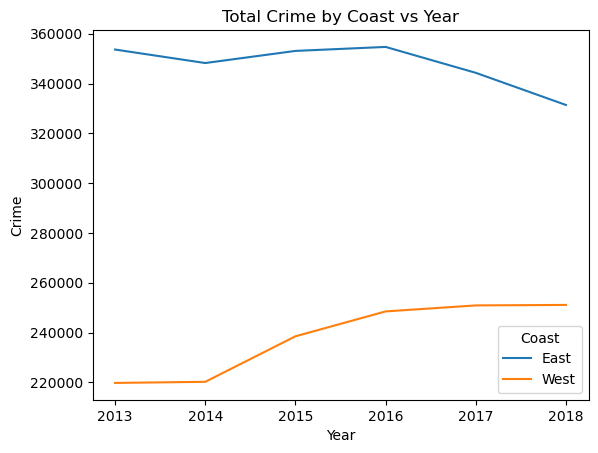

In [252]:
crime_east = (crime_df[crime_df['State'].isin(East)]).loc[:, ['State','Violent_Crime', 'Year']]
crime_east = duckdb.sql( """ Select Sum(Violent_Crime) AS Crime,
                        Year FROM crime_east GROUP BY Year ORDER BY Year""").df()
crime_east['Coast'] = 'East'

crime_west = crime_df[crime_df['State'].isin(West)].loc[:, ['State','Violent_Crime','Year']]
crime_west = duckdb.sql( """ Select  Sum(Violent_Crime) AS Crime,
                        Year FROM crime_west GROUP BY Year ORDER BY Year""").df()
crime_west['Coast']= 'West'

crime = pd.concat([crime_east, crime_west], axis=0)
#print(crime)

sns.lineplot(data = crime, x = 'Year', y = 'Crime', hue = 'Coast').set_title('Total Crime by Coast vs Year');

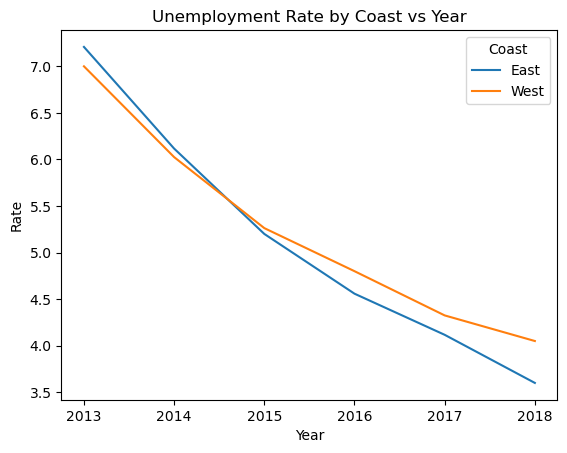

In [253]:
job2_df = pd.melt(job_df, id_vars = 'Area', var_name='Year', value_name= 'Rate').dropna()

job_east = (job2_df[job2_df['Area'].isin(East)]).loc[:, ['Area','Rate', 'Year']]
job_east = duckdb.sql("""Select AVG(Rate) as Rate, Year FROM job_east GROUP BY Year ORDER BY Year""").df()
job_east['Coast']  = 'East'

job_west = (job2_df[job2_df['Area'].isin(West)]).loc[:, ['Area','Rate', 'Year']]
job_west = duckdb.sql("""Select AVG(Rate) as Rate, Year FROM job_west GROUP BY Year ORDER BY Year""").df()
job_west['Coast'] = 'West'

job_fin= pd.concat([job_east, job_west], axis = 0)
job_fin.reset_index(inplace = True, drop = True)
sns.lineplot(data = job_fin, x = 'Year', y = 'Rate', hue = 'Coast').set(title = 'Unemployment Rate by Coast vs Year');


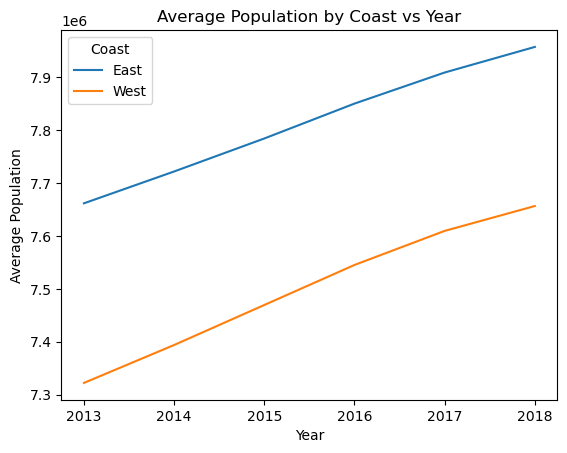

In [254]:
pop_east = (pop_df[pop_df['State'].isin(East)]).loc[:, ['2013', '2014', '2015', '2016', '2017', '2018']]
pop_east = pd.melt(pop_east, value_vars = ['2013', '2014', '2015', '2016', '2017', '2018'], var_name = "Year", value_name = "Pop").dropna()
pop_east = duckdb.sql("SELECT AVG(Pop) AS avg_pop, Year FROM pop_east GROUP BY Year").df()
pop_west = (pop_df[pop_df['State'].isin(West)]).loc[:, ['2013', '2014', '2015', '2016', '2017', '2018']]
pop_west = pd.melt(pop_west, value_vars = ['2013', '2014', '2015', '2016', '2017', '2018'], var_name = "Year", value_name = "Pop").dropna()
pop_west = duckdb.sql("SELECT AVG(Pop) AS avg_pop, Year FROM pop_west GROUP BY Year").df()

pop_east['Year'] = pop_east['Year'].astype(int)
pop_west['Year'] = pop_west['Year'].astype(int)

pop_east['Coast'] = 'East'
pop_west['Coast'] = 'West'

pop_combined = pd.concat([pop_east, pop_west], axis = 0)
pop_combined.reset_index(inplace = True, drop = True)
sns.lineplot(data = pop_combined, x = 'Year', y = 'avg_pop', hue = 'Coast').set(title = 'Average Population by Coast vs Year')

plt.ylabel("Average Population")
plt.show()

## JASMINE'S GRAPHS .....

In [255]:
# Reshape the unemployment data to long format... one row per state-year
unemployment_df_long = job_df.melt(id_vars='Area', var_name='Year', value_name='Unemployment')
#remove USA because that is not a state
unemployment_df_long = unemployment_df_long[unemployment_df_long['Area'] != 'United States']

# Convert 'Year' to integer
unemployment_df_long['Year'] = unemployment_df_long['Year'].astype(int)

# Calculate the average unemployment rate from 2013 to 2018 for each state
avg_unemployment = unemployment_df_long.groupby('Area')['Unemployment'].mean().reset_index()
avg_unemployment.rename(columns={'Area': 'State', 'Unemployment': 'Avg_Unemployment'}, inplace=True)

# Display the result
print(round(avg_unemployment,2).head())

        State  Avg_Unemployment
0     Alabama              5.70
1      Alaska              6.82
2     Arizona              5.95
3    Arkansas              4.93
4  California              6.18


In [256]:
#average of crime per state over the 2013 to 2018 time period
avg_violent_crime = crime_filtered_years.groupby('State')['Violent_Crime'].mean().reset_index()

#Rename the columns for clarity
avg_violent_crime.rename(columns={'Violent_Crime': 'Avg_Violent_Crime'}, inplace=True)

#Round the average violent crime to 2 decimal places
avg_violent_crime['Avg_Violent_Crime'] = avg_violent_crime['Avg_Violent_Crime'].round(2)

#average of population per state over the 2013 to 2018 time period
avg_population = crime_filtered_years.groupby('State')['Population'].mean().reset_index()

#Rename the column for clarity
avg_population.rename(columns={'Population': 'Avg_Population'}, inplace=True)

#Merge this back into the original crime DataFrame
averages_df = pd.merge(avg_violent_crime, avg_population, on='State')

#Calculate the crime rate using the average population WHERE Crime Rate = (Violent_Crime / Avg_Population) * 100,000
average_crime_percent = ((averages_df['Avg_Violent_Crime']) / (averages_df['Avg_Population']))*100000
averages_df["avg_crime_rate"] = average_crime_percent
print(averages_df)


                   State  Avg_Violent_Crime  Avg_Population  avg_crime_rate
0                Alabama           23572.00    4.859605e+06      485.060033
1                 Alaska            5607.17    7.380768e+05      759.700040
2                Arizona           30701.33    6.882814e+06      446.057786
3               Arkansas           15697.50    2.984069e+06      526.043466
4             California          167563.67    3.906251e+07      428.962927
5               Colorado           18786.00    5.485631e+06      342.458314
6            Connecticut            8299.33    3.585320e+06      231.480894
7               Delaware            4546.00    9.467565e+05      480.165703
8   District of Columbia            7893.17    6.768163e+05     1166.220378
9                Florida           88874.83    2.043809e+07      434.849099
10               Georgia           38061.67    1.025485e+07      371.157775
11                Hawaii            3633.17    1.422388e+06      255.427552
12          

In [257]:
# Calculate the correlation between unemployment and violent crime
merged_df = pd.merge(avg_unemployment, averages_df, on='State')
merged_df.head()
correlation = merged_df['Avg_Unemployment'].corr(merged_df['avg_crime_rate'])
print(f"Correlation between Unemployment and Violent Crime: {correlation:.2f}")

Correlation between Unemployment and Violent Crime: 0.53


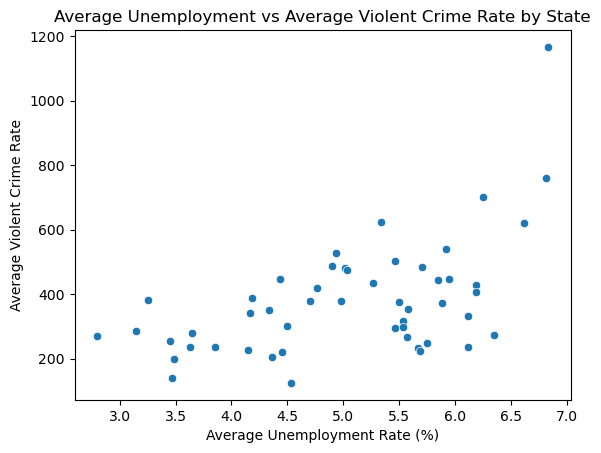

In [258]:
# Scatter plot of Average Unemployment vs Average Violent Crime
sns.scatterplot(x='Avg_Unemployment', y='avg_crime_rate', data=merged_df)
plt.title('Average Unemployment vs Average Violent Crime Rate by State')
plt.xlabel('Average Unemployment Rate (%)')
plt.ylabel('Average Violent Crime Rate')
plt.show()

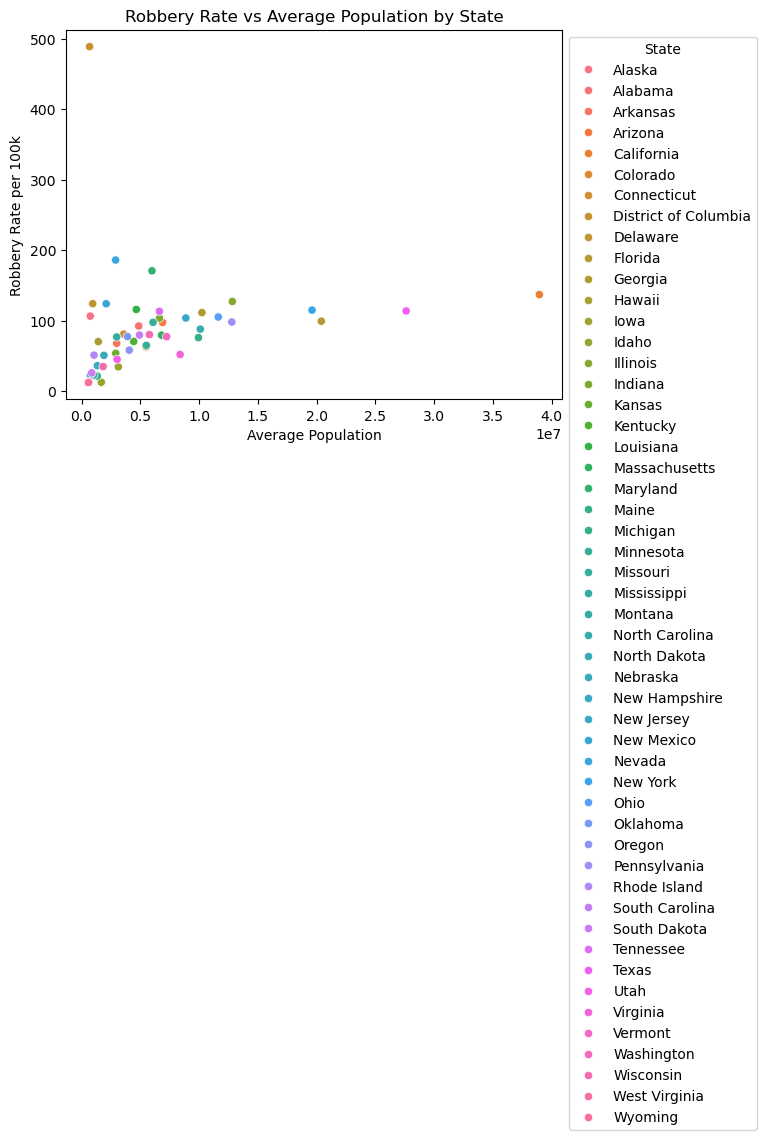

In [259]:
#finding the average robbery rate
crime_filtered = crime_df[(crime_df['Year'] >= 2013) & (crime_df['Year'] <= 2018)]

#calculating the average robbery for each state across 2013-2018. I am going to use unique to get the unique states so we can get one state per the 2013-2018 timeframe
states = crime_filtered['State'].unique()

#Creating the lists
avg_robbery_list = []
population_list = []
robbery_rate_list = []

#looping through each state to find the robbery rates
for state in states:
    state_data = crime_filtered.loc[crime_filtered['State'] == state]
    avg_robbery = state_data['Robbery'].mean()
    population = state_data['Population'].mean()
    robbery_rate = (avg_robbery/population) * 100000

    robbery_rate_list.append(robbery_rate)

robbery_avg_df = pd.DataFrame({
    'State': states,
    'Robbery_Rate_Per_100k': robbery_rate_list
})

#robbery vs population
pop_df['Avg_Population'] = pop_df.loc[:,['2013', '2014', '2015', '2016', '2017', '2018']].mean(axis=1)
merged_df = pd.merge(robbery_avg_df, pop_df.loc[:,['State', 'Avg_Population']], on='State')

plot = sns.scatterplot(data= merged_df, x='Avg_Population', y='Robbery_Rate_Per_100k', hue='State')

plt.title('Robbery Rate vs Average Population by State')
plt.xlabel('Average Population')
plt.ylabel('Robbery Rate per 100k')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.show()

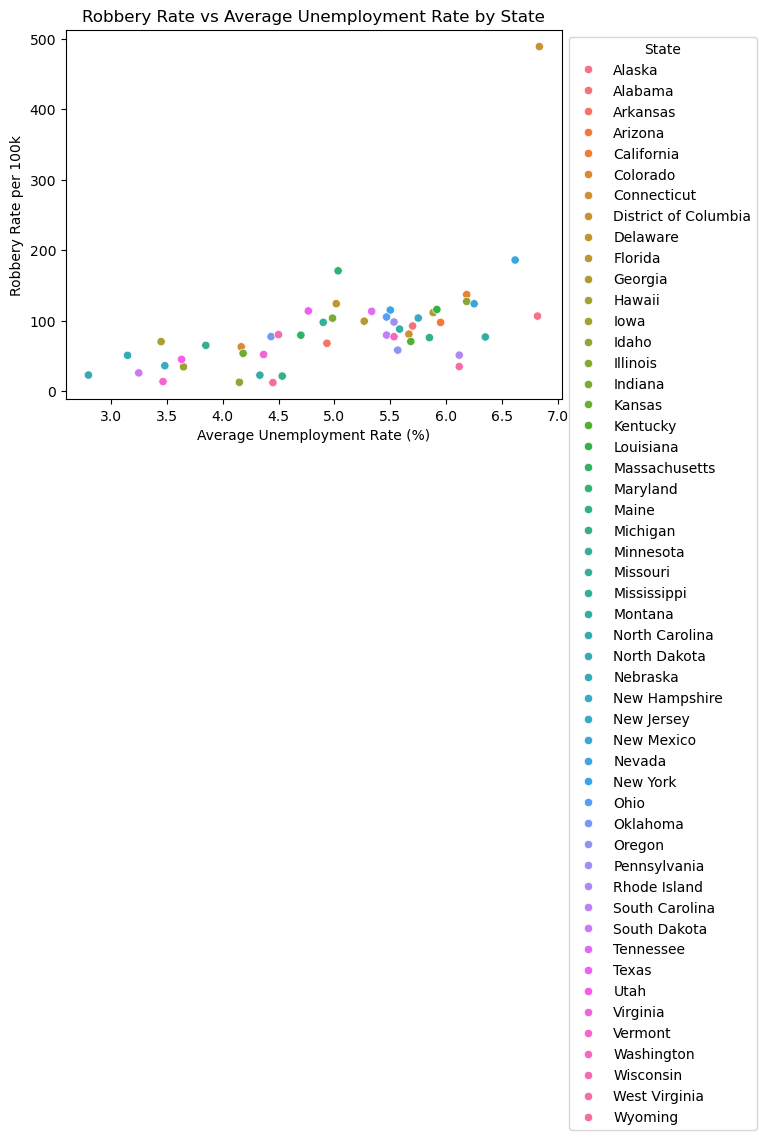

In [260]:
#robbery vs unemployment rate
robbery_unemployment_df = pd.merge(robbery_avg_df, avg_unemployment[['State', 'Avg_Unemployment']], on='State')

plot = sns.scatterplot(x=robbery_unemployment_df['Avg_Unemployment'], y=robbery_unemployment_df['Robbery_Rate_Per_100k'], hue=robbery_unemployment_df['State'])

plt.title('Robbery Rate vs Average Unemployment Rate by State')
plt.xlabel('Average Unemployment Rate (%)')
plt.ylabel('Robbery Rate per 100k')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.show()

## SAVITTA'S GRAPHS  .....

In [261]:
income_melt = pd.melt(income_df, id_vars='State', var_name = 'Year', value_name='Median_Income')
income_melt['Year'] = income_melt['Year'].astype(int)
income_melt.head()

,State,Year,Median_Income
0,Alabama,2018,49936.0
1,Alaska,2018,68734.0
2,Arizona,2018,62283.0
3,Arkansas,2018,49781.0
4,California,2018,70489.0


In [262]:
income_crime = duckdb.sql(""" Select i.State, i.Year, Median_Income, Violent_Crime
                          FROM income_melt AS i JOIN crime_df as c ON i.State = c.State AND i.Year = c.Year""").df()
income_crime

,State,Year,Median_Income,Violent_Crime
0,Alaska,2013,72472.0,4709
1,Arkansas,2013,39376.0,13705
2,Arizona,2013,52611.0,27576
3,California,2013,60794.0,154739
4,Colorado,2013,67912.0,16099
...,...,...,...,...
277,Missouri,2018,61726.0,30696
278,South Dakota,2018,59463.0,3483
279,Virginia,2018,77151.0,17357
280,Arkansas,2017,48829.0,16996


In [263]:
avg_ic = duckdb.sql(""" Select State, AVG(Median_Income) as AvgIncome, AVG(Violent_Crime) as AvgCrime FROM income_crime
                    GROUP BY State ORDER BY State ASC""").df()
#print(avg_ic)
income_crime_corr = avg_ic['AvgIncome'].corr(avg_ic['AvgCrime'])
print(f'\nCorrelation between median income and violent crime is', income_crime_corr)


Correlation between median income and violent crime is -0.05071859553466086


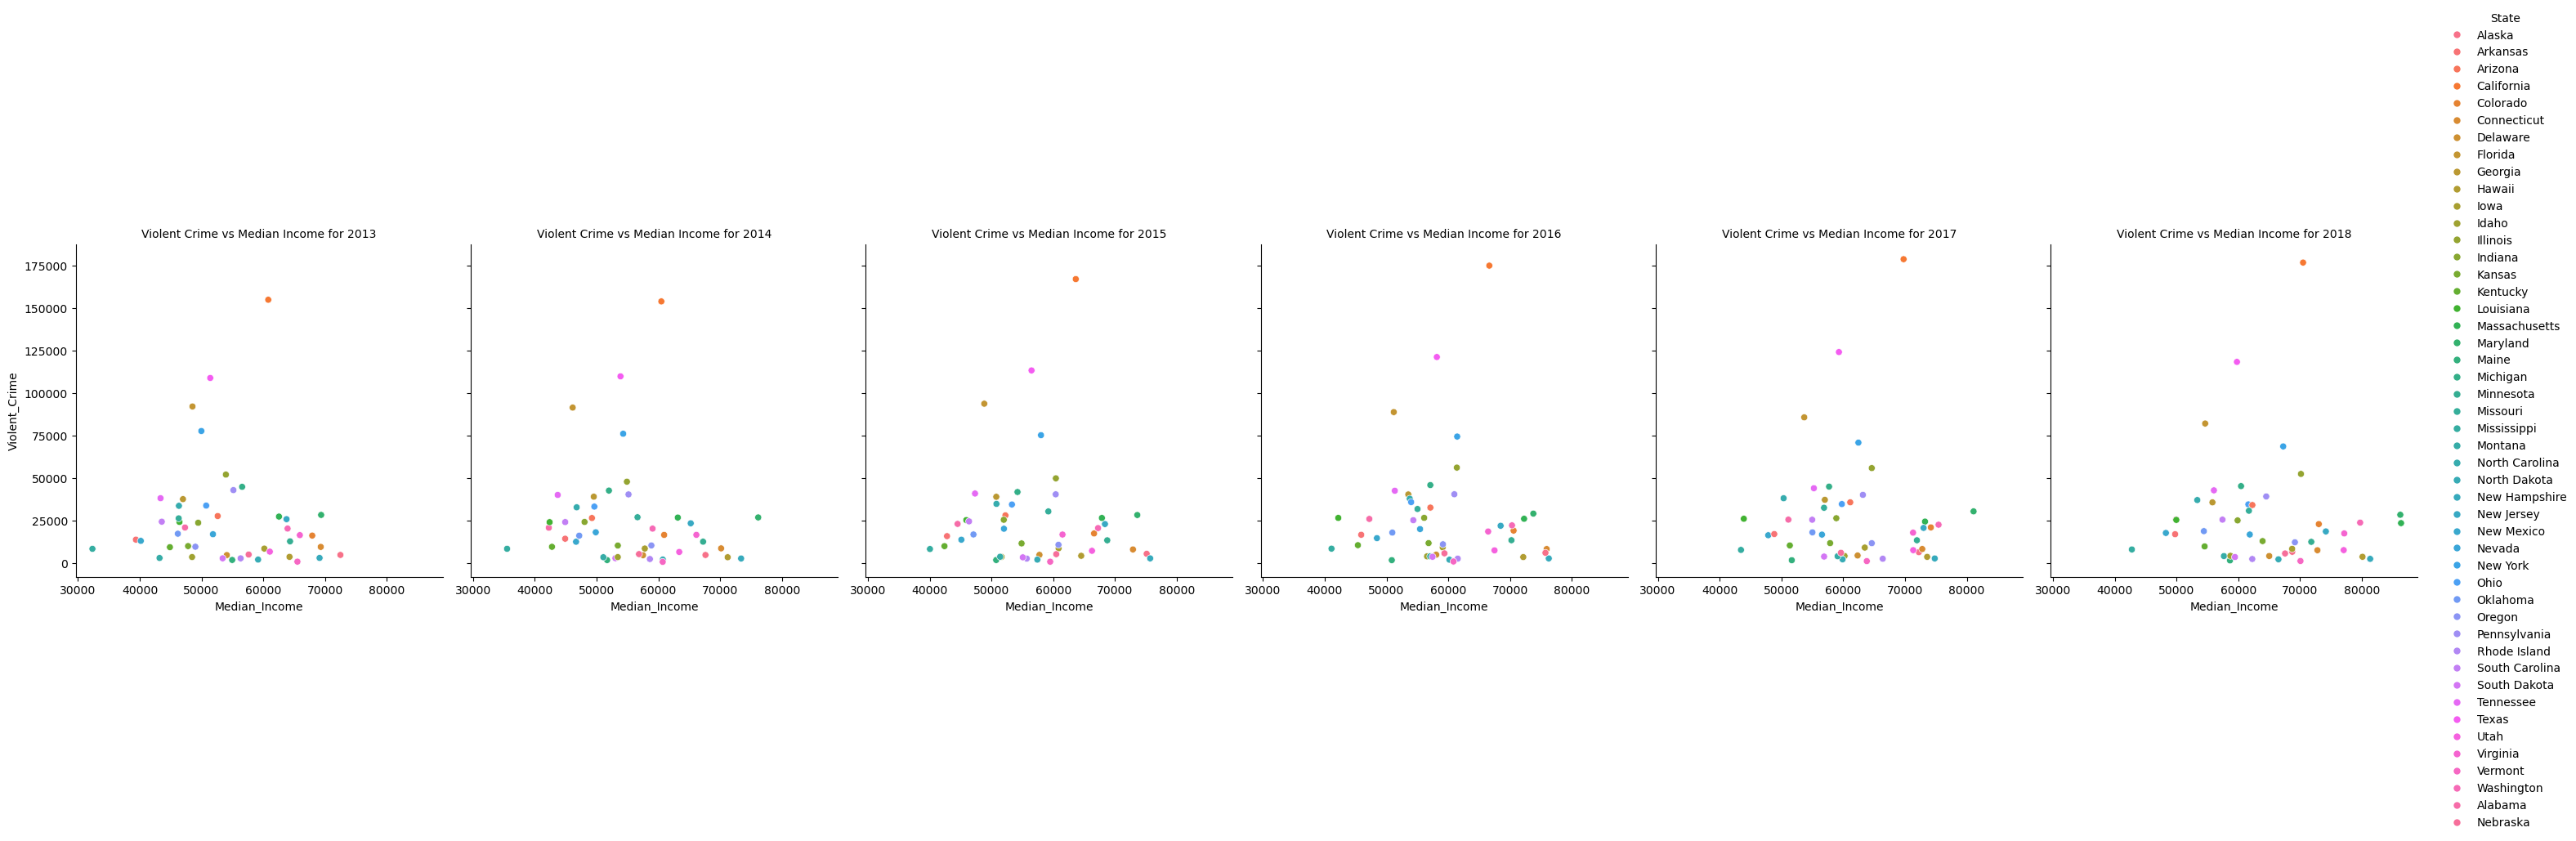

In [264]:
sns.relplot(data = income_crime, x = 'Median_Income', y = 'Violent_Crime',
            col = 'Year', hue = 'State').set_titles("Violent Crime vs Median Income for {col_name}");

In [265]:
rate = (crime_df['Violent_Crime']/crime_df['Population'])*100000
crime_rate = pd.DataFrame({'State': crime_df['State'], 'Crime_Rate': rate, 'Year': crime_df['Year']})
crime_rate

,State,Crime_Rate,Year
0,Alaska,638.717194,2013
1,Alabama,430.989186,2013
2,Arkansas,463.200018,2013
3,Arizona,415.614355,2013
4,California,402.636980,2013
...,...,...,...
301,Vermont,184.990022,2018
302,Washington,315.250040,2018
303,Wisconsin,299.014741,2018
304,West Virginia,299.896192,2018


In [266]:
rate_2018 = pd.DataFrame(data = ((crime_rate.loc[crime_rate['Year']==2018]).loc[:, ['State', 'Crime_Rate']]))
rate_2018.head()

,State,Crime_Rate
255,Alaska,891.668106
256,Alabama,523.090603
257,Arkansas,561.644505
258,Arizona,475.731850
259,California,447.533941


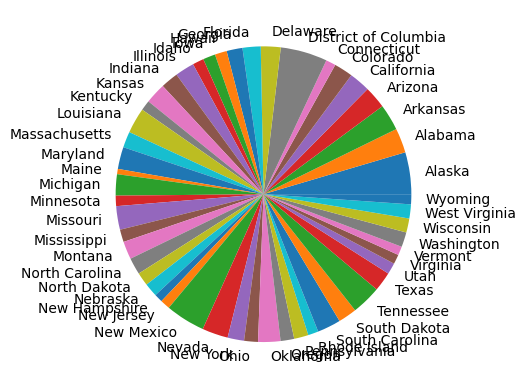

In [267]:
plt.pie(x=rate_2018['Crime_Rate'], labels = rate_2018['State']);

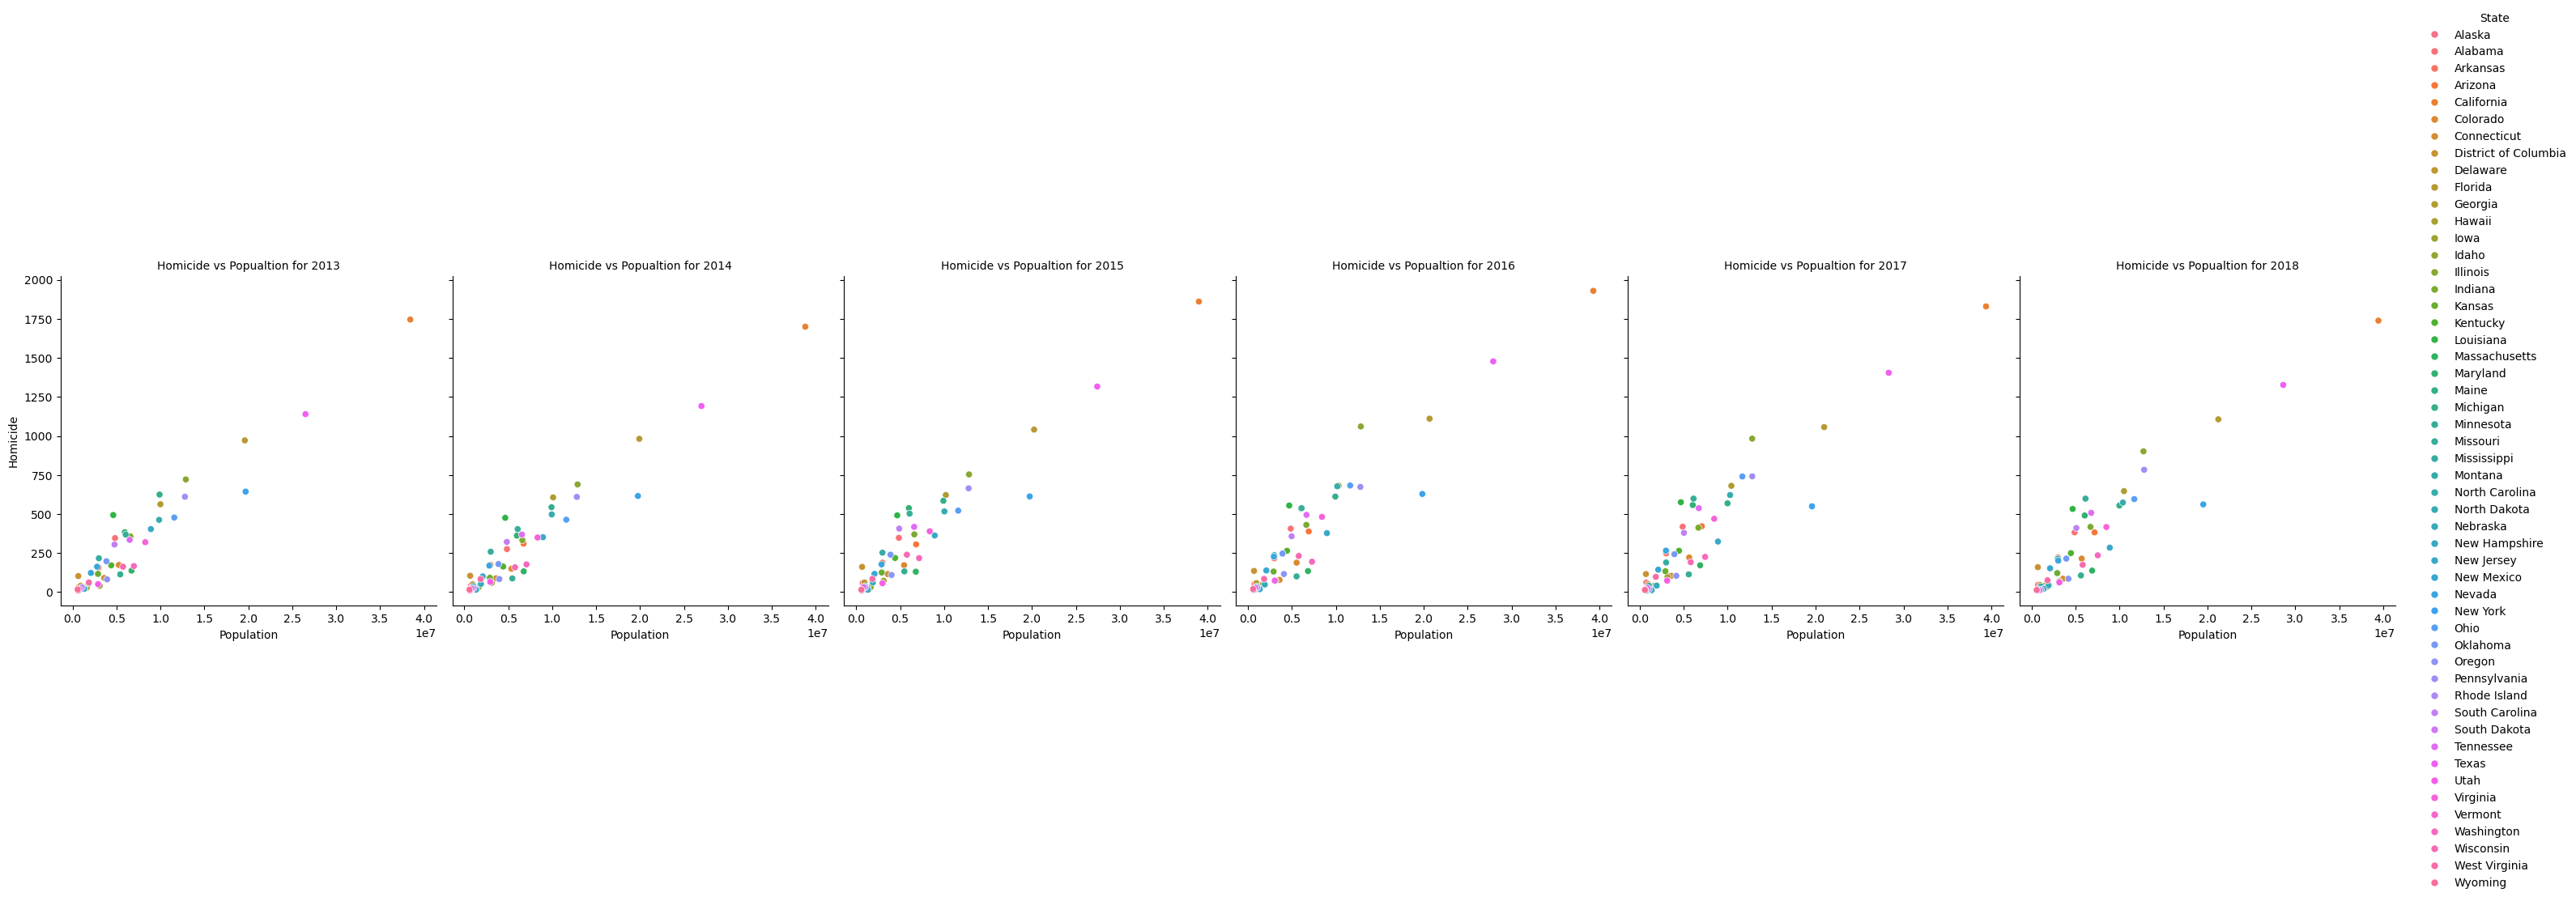

In [268]:
#homicide_population = duckdb.sql(""" SELECT Homicide, Population, Year FROM crime_df GROUP BY Year""").df()
sns.relplot(data = crime_df, x = 'Population', y = 'Homicide',
            col = 'Year', hue = 'State').set_titles("Homicide vs Popualtion for {col_name}");

In [269]:
homicide_rate = crime_df['Homicide']/crime_df['Population']*100000
homicide_df = (crime_df.loc[:, ['State', 'Year']])
homicide_df = pd.DataFrame({'State':crime_df['State'], 'Year':crime_df['Year'], 'HomicideRate': homicide_rate})
homicide_df.head()

,State,Year,HomicideRate
0,Alaska,2013,4.611676
1,Alabama,2013,7.157639
2,Arkansas,2013,5.340066
3,Arizona,2013,5.350417
4,California,2013,4.543161


In [270]:
job2_df.rename(columns = {'Area':'State'}, inplace=True)
job2_df['Year'] = job2_df['Year'].astype(int)
homicide_unemp  = homicide_df.merge(job2_df, on = ['State', 'Year'])
homicide_unemp.rename(columns = {'Rate':'UnemploymentRate'}, inplace=True)
homicide_unemp.head()

,State,Year,HomicideRate,UnemploymentRate
0,Alaska,2013,4.611676,7.0
1,Alabama,2013,7.157639,7.2
2,Arkansas,2013,5.340066,7.2
3,Arizona,2013,5.350417,7.7
4,California,2013,4.543161,8.9


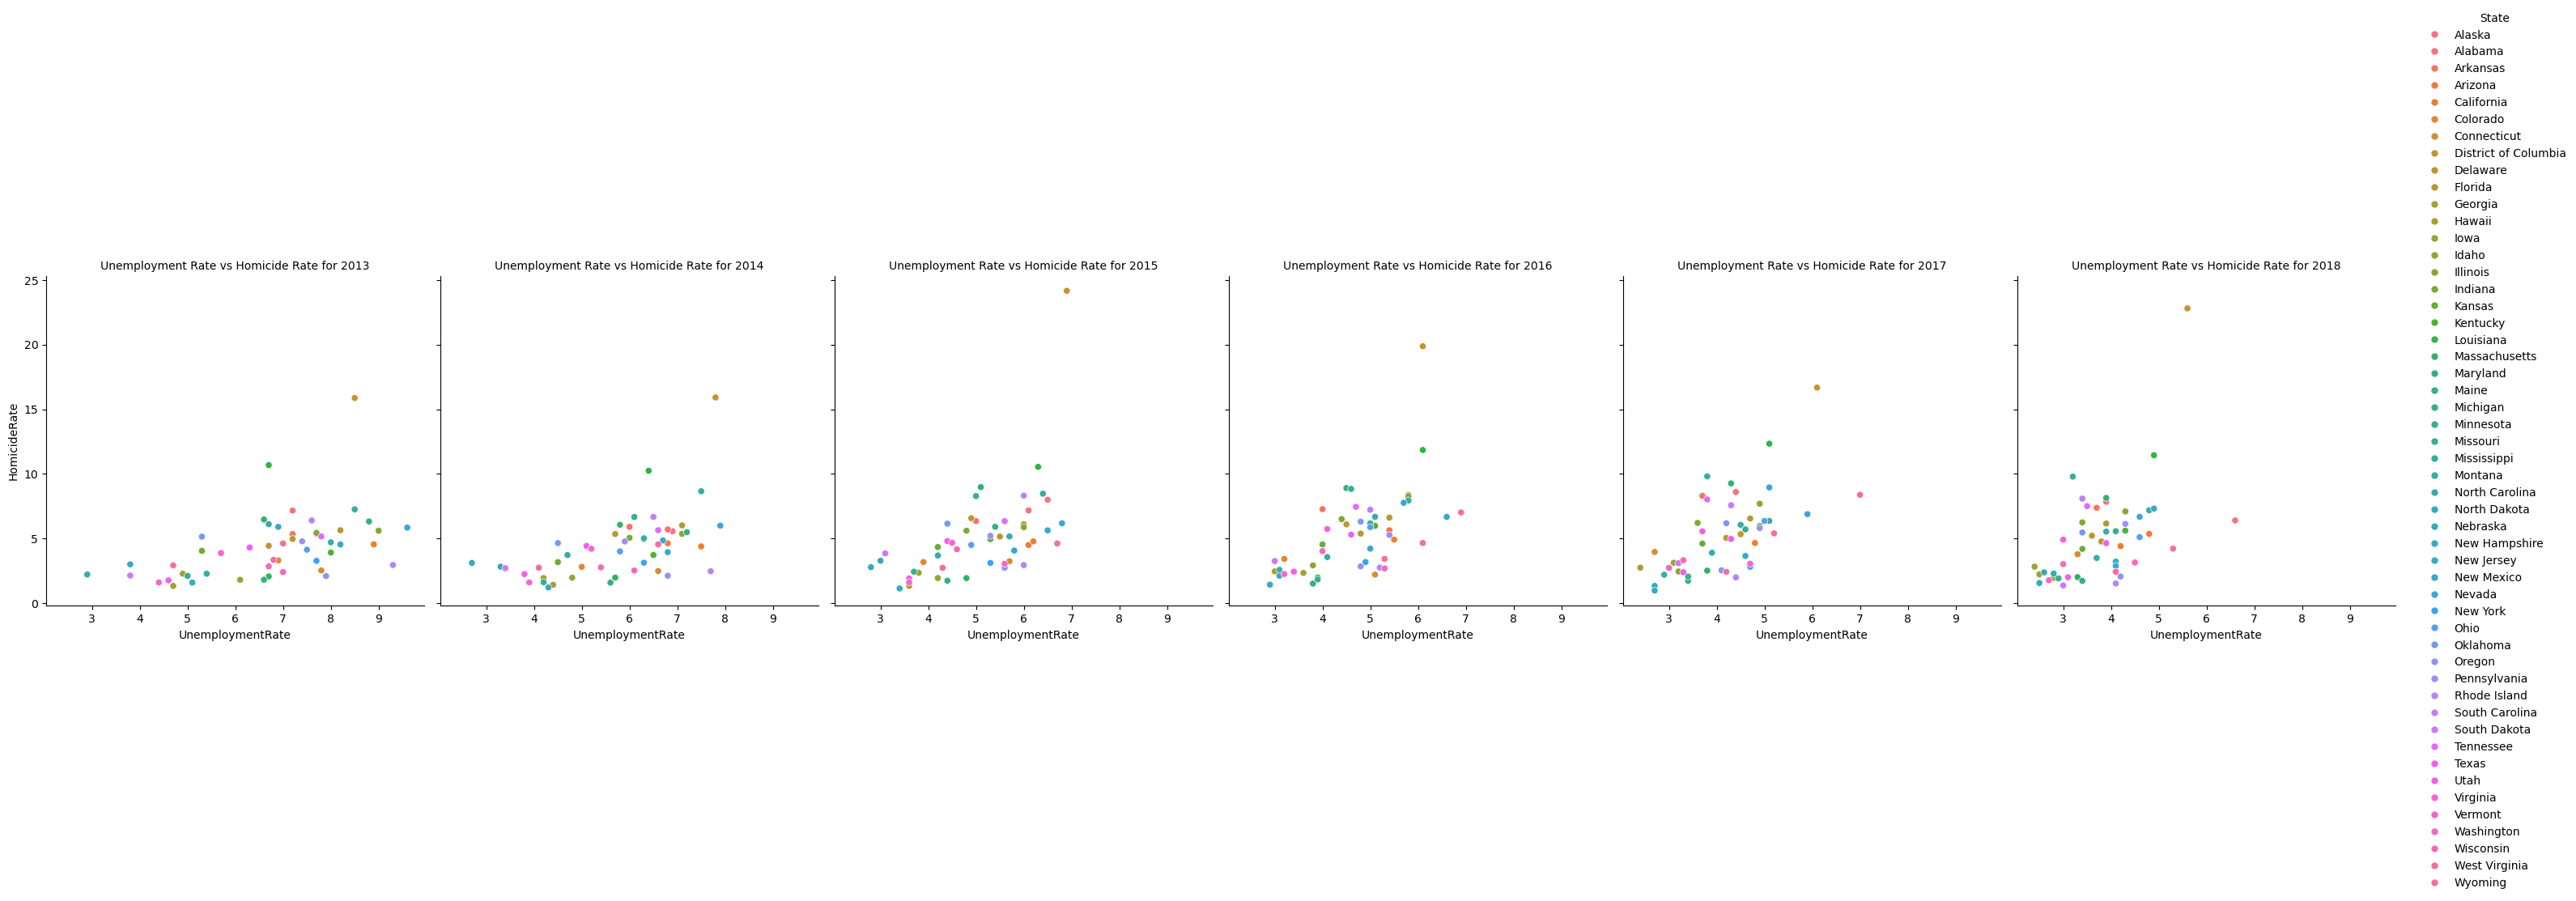

In [271]:
sns.relplot(data = homicide_unemp, x = 'UnemploymentRate', y = 'HomicideRate',
            col = 'Year', hue = 'State').set_titles("Unemployment Rate vs Homicide Rate for {col_name}");

In [272]:
rape_rate = crime_df['Rape']/crime_df['Population']*100000
rape_df = (crime_df.loc[:, ['State', 'Year']])
rape_df = pd.DataFrame({'State':crime_df['State'], 'Year':crime_df['Year'], 'RapeRate': rape_rate})
rape_df.head()

,State,Year,RapeRate
0,Alaska,2013,125.464728
1,Alabama,2013,42.511413
2,Arkansas,2013,50.358849
3,Arizona,2013,47.837248
4,California,2013,26.863455


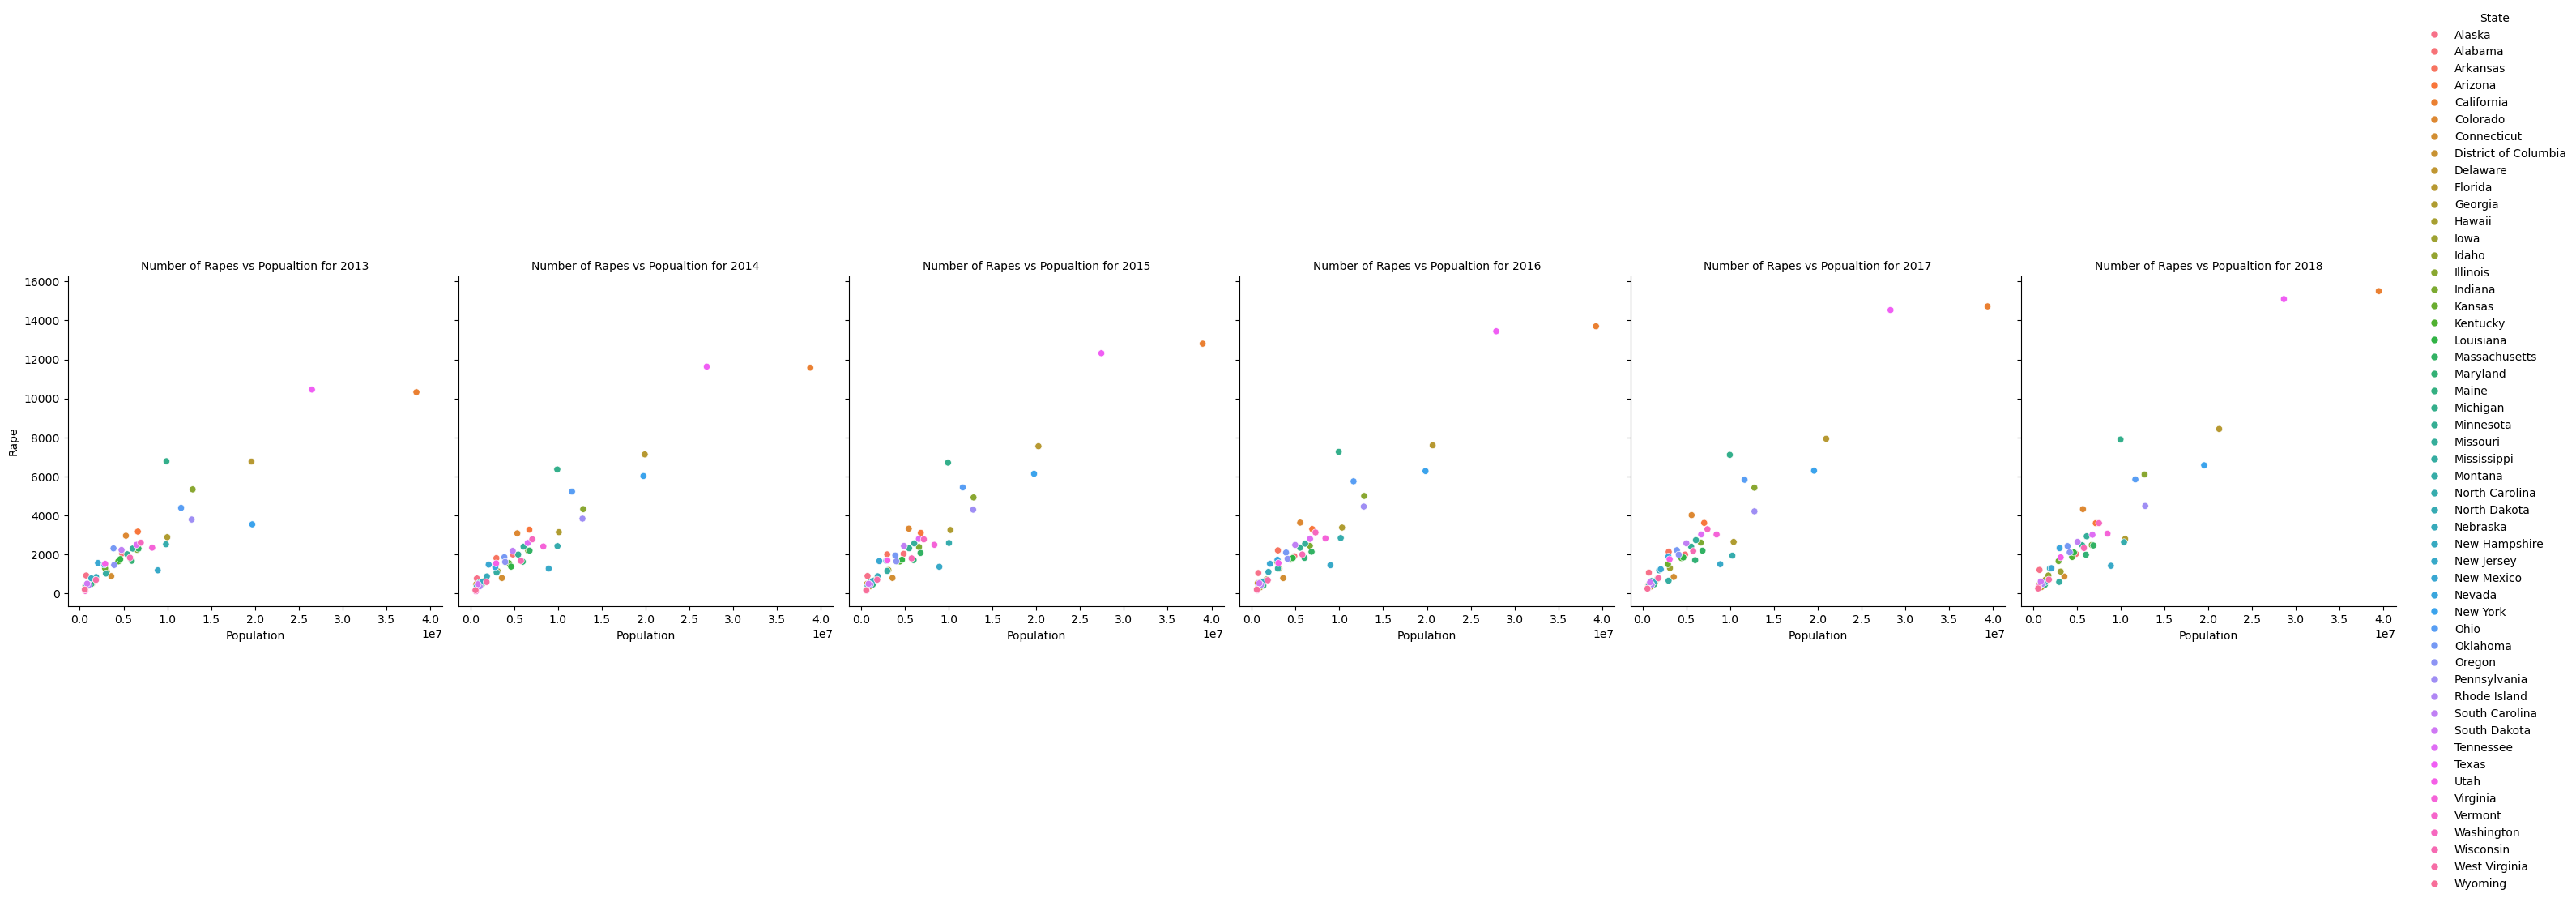

In [273]:
sns.relplot(data = crime_df, x = 'Population', y = 'Rape',
            col = 'Year', hue = 'State').set_titles("Number of Rapes vs Popualtion for {col_name}");

In [274]:
rape_unemp  = rape_df.merge(job2_df, on = ['State', 'Year'])
rape_unemp.rename(columns = {'Rate':'UnemploymentRate'}, inplace=True)
rape_unemp.head()

,State,Year,RapeRate,UnemploymentRate
0,Alaska,2013,125.464728,7.0
1,Alabama,2013,42.511413,7.2
2,Arkansas,2013,50.358849,7.2
3,Arizona,2013,47.837248,7.7
4,California,2013,26.863455,8.9


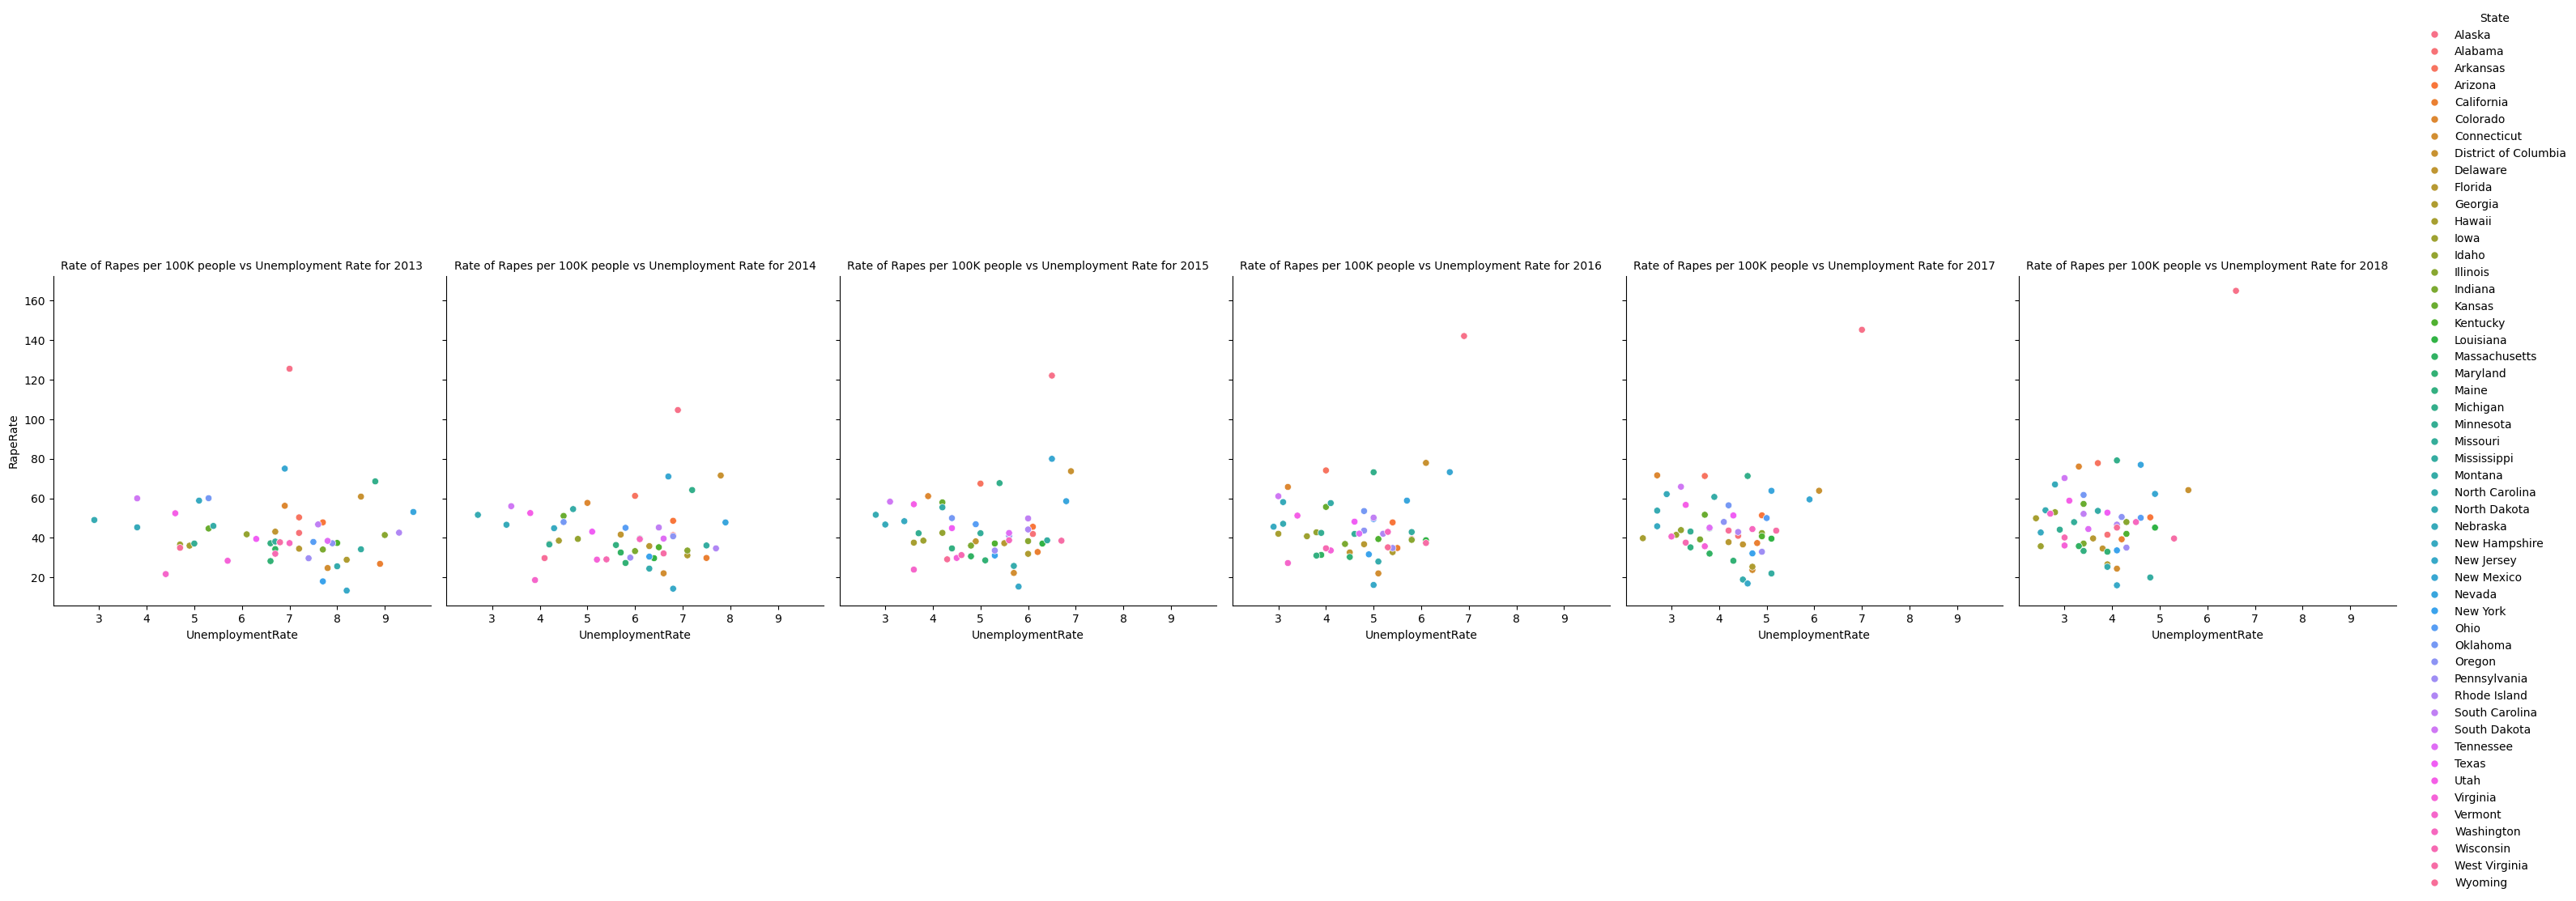

In [275]:
sns.relplot(data = rape_unemp, x = 'UnemploymentRate', y = 'RapeRate',
            col = 'Year', hue = 'State').set_titles("Rate of Rapes per 100K people vs Unemployment Rate for {col_name}");

## CARINA'S GRAPHS .....

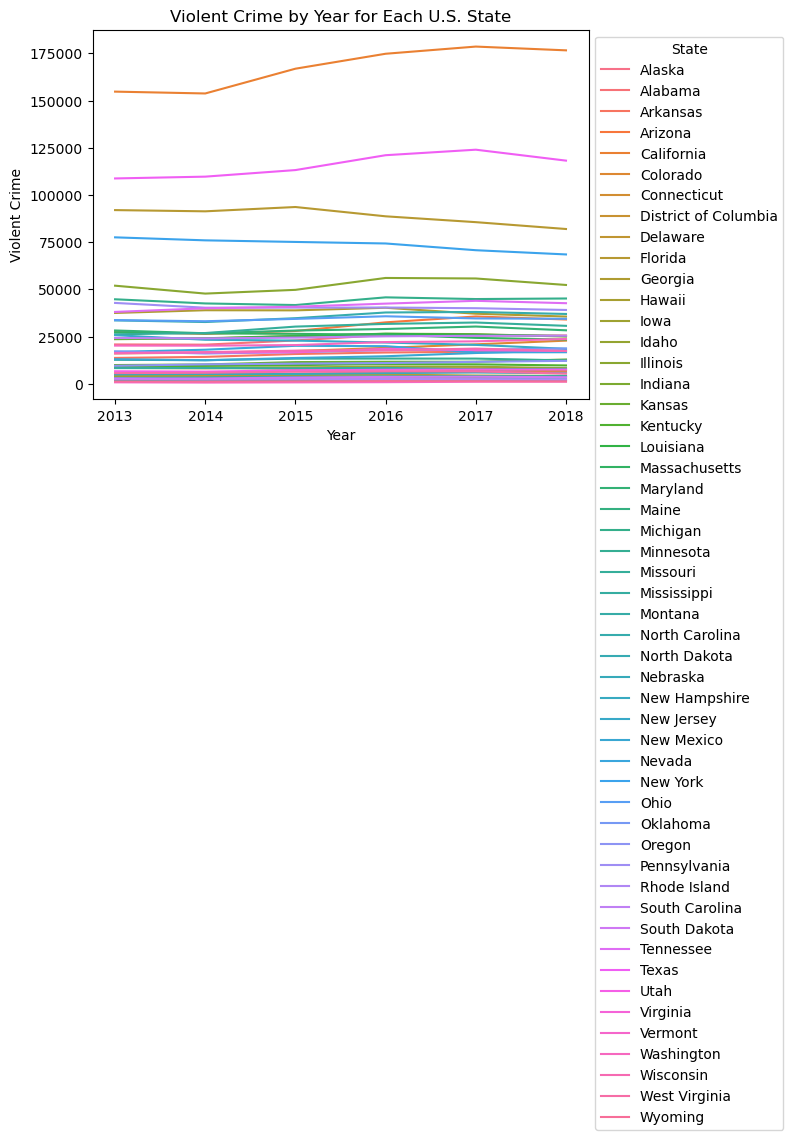

The top five states with the most violent crime from 2013 to 2018 are ['California', 'Texas', 'Florida', 'New York', 'Illinois'].


In [276]:
# Year (x) vs crime (a line for each state), line graph
plot = sns.lineplot(x = 'Year', y = 'Violent_Crime', data = crime_df, hue = 'State')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.title('Violent Crime by Year for Each U.S. State')
plt.ylabel('Violent Crime')
plt.xlabel('Year')
plt.show()

sum_str = duckdb.sql("SELECT State, SUM(Violent_Crime) AS sum_crime FROM crime_df GROUP BY State ORDER BY sum_crime DESC LIMIT 5").df()
print(f"The top five states with the most violent crime from 2013 to 2018 are {sum_str['State'].to_list()}.")


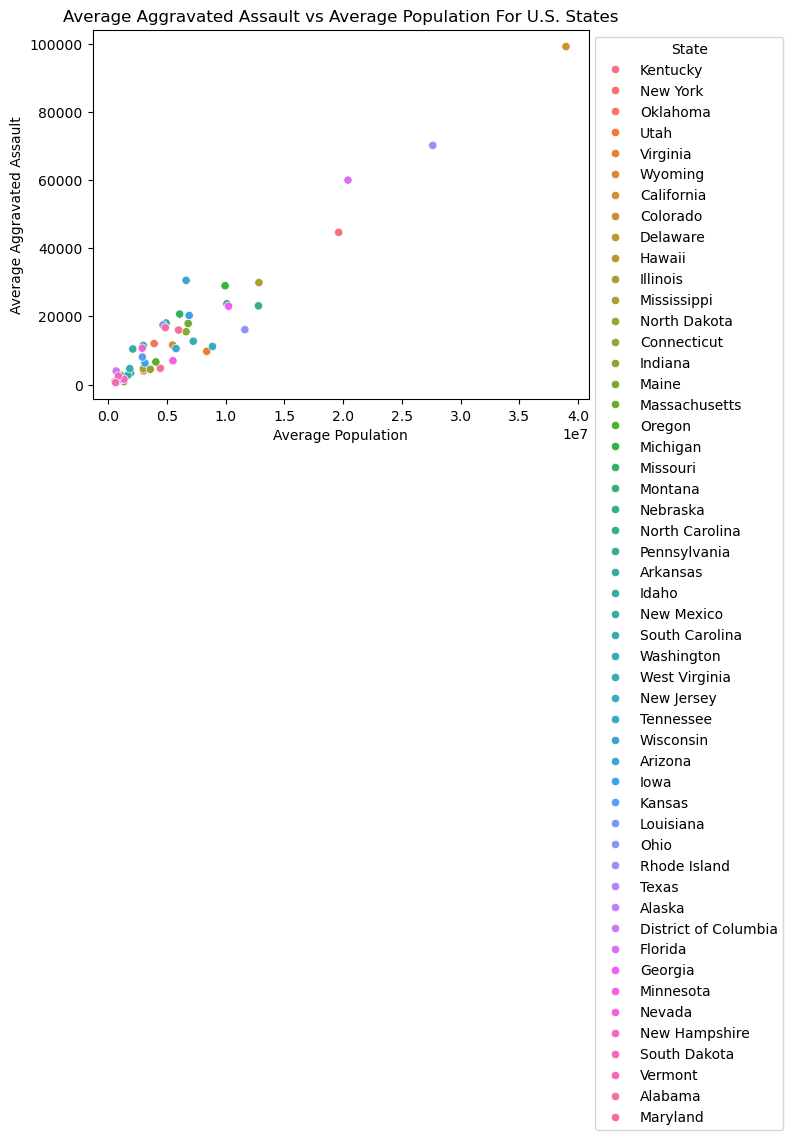

In [277]:
# aggravated assault vs population

pop_df_melt = pd.melt(pop_df, value_vars = ['2013', '2014', '2015', '2016', '2017', '2018'], id_vars = "State", var_name = "Year", value_name = "Pop").dropna()
crime_df.head()

avg_aggravated = duckdb.sql("SELECT State, AVG(Aggravated_Assault) AS avg_aggravated_assault \
                            FROM crime_df GROUP BY State").df()
avg_pop_df = duckdb.sql("SELECT State, AVG(Pop) AS avg_pop FROM pop_df_melt GROUP BY State").df()
merged = duckdb.sql("SELECT avg_pop_df.avg_pop, avg_aggravated.avg_aggravated_assault, \
                    avg_pop_df.State FROM avg_aggravated, avg_pop_df \
                    WHERE avg_aggravated.State = avg_pop_df.State").df()


plot = sns.scatterplot(x = merged['avg_pop'], y = merged['avg_aggravated_assault'], hue = merged['State'])
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.title('Average Aggravated Assault vs Average Population For U.S. States')
plt.ylabel('Average Aggravated Assault')
plt.xlabel('Average Population')
plt.show()


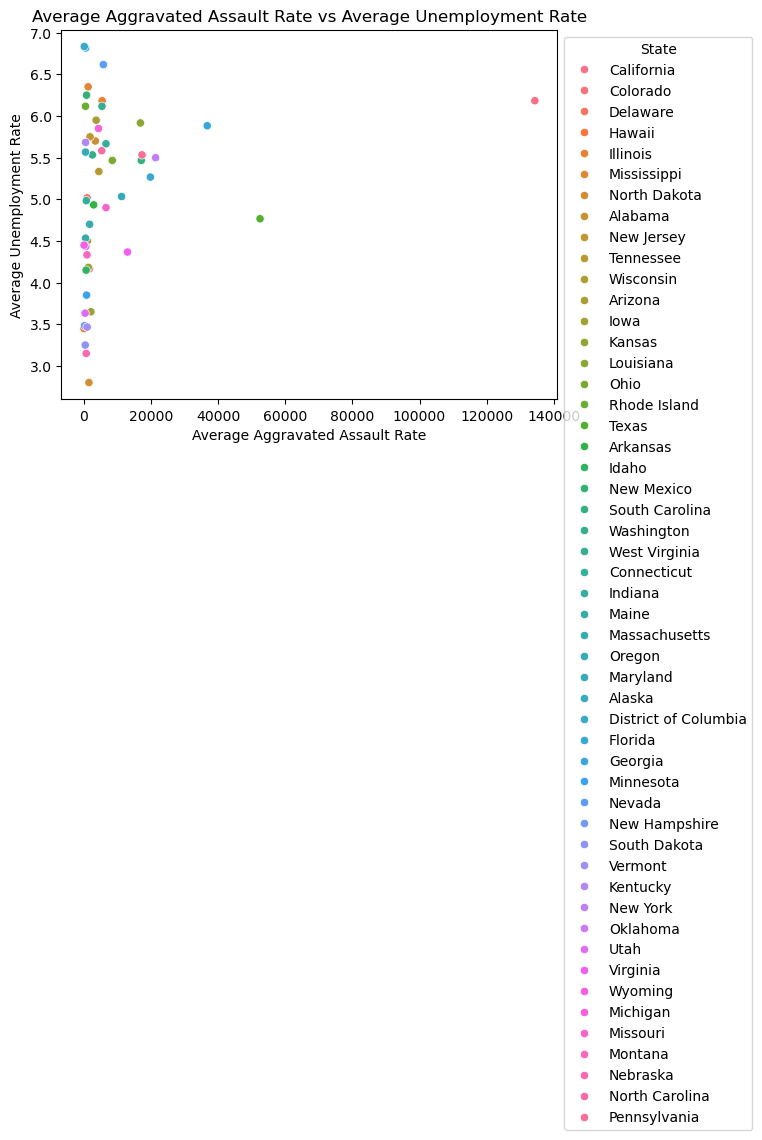

In [278]:
#aggravated assault rate vs unemployment rate for U.S. States

job_df_melt = pd.melt(job_df, id_vars = 'Area', var_name='Year', value_name= 'Rate').dropna()

avg_job_df = duckdb.sql("SELECT Area, AVG(Rate) AS avg_ump FROM job_df_melt GROUP BY Area")

aggravated_rate = (avg_aggravated['avg_aggravated_assault']/averages_df['Avg_Population']) * 1000000
avg_aggravated['aggravated_rate'] = aggravated_rate

merged_df = duckdb.sql("SELECT avg_job_df.avg_ump, avg_aggravated.aggravated_rate, avg_job_df.Area AS State \
                       FROM avg_job_df, avg_aggravated WHERE avg_job_df.Area = avg_aggravated.State").df()

plot = sns.scatterplot(x = merged_df['aggravated_rate'], y = merged_df['avg_ump'], hue = merged_df["State"])
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.title('Average Aggravated Assault Rate vs Average Unemployment Rate')
plt.ylabel('Average Unemployment Rate')
plt.xlabel('Average Aggravated Assault Rate')
plt.show()
